# Imports

In [1]:
using DataFrames
using CSV
using MLJ
using Plots
using StatsBase

include("../../lib.jl")

ENV["LINES"]=30;

# Datasets

In [2]:
data = CSV.read("./data.csv")

,Class_Name,Left_Weight,Left_Distance,Right_Weight,Right_Distance
,String,Int64,Int64,Int64,Int64
1,B,1,1,1,1
2,R,1,1,1,2
3,R,1,1,1,3
4,R,1,1,1,4
5,R,1,1,1,5
6,R,1,1,2,1
7,R,1,1,2,2
8,R,1,1,2,3
9,R,1,1,2,4


In [3]:
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,Class_Name,,B,,R,3,,String
2,Left_Weight,3.0,1,3.0,5,,,Int64
3,Left_Distance,3.0,1,3.0,5,,,Int64
4,Right_Weight,3.0,1,3.0,5,,,Int64
5,Right_Distance,3.0,1,3.0,5,,,Int64


Look at class labels to see if dataset is imbalanced

In [4]:
label_counts = countmap(data[:Class_Name])

Dict{String,Int64} with 3 entries:
  "B" => 49
  "L" => 288
  "R" => 288

In [5]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

3-element Array{Float64,1}:
 0.0784
 0.4608
 0.4608

Get data ready for training

In [6]:
coerce!(data, :Class_Name=>Multiclass,
              :Left_Weight=>Continuous,
              :Right_Weight=>Continuous,
              :Left_Distance=>Continuous,
              :Right_Distance=>Continuous)
schema(data)

┌────────────────┬─────────────────────────────────┬───────────────┐
│ _.names        │ _.types                         │ _.scitypes    │
├────────────────┼─────────────────────────────────┼───────────────┤
│ Class_Name     │ CategoricalValue{String,UInt32} │ Multiclass{3} │
│ Left_Weight    │ Float64                         │ Continuous    │
│ Left_Distance  │ Float64                         │ Continuous    │
│ Right_Weight   │ Float64                         │ Continuous    │
│ Right_Distance │ Float64                         │ Continuous    │
└────────────────┴─────────────────────────────────┴───────────────┘
_.nrows = 625


In [7]:
y, X = unpack(data, ==(:Class_Name), colname->true)

(CategoricalValue{String,UInt32}["B", "R", "R", "R", "R", "R", "R", "R", "R", "R"  …  "L", "L", "L", "L", "L", "L", "L", "L", "L", "B"], 625×4 DataFrame
│ Row │ Left_Weight │ Left_Distance │ Right_Weight │ Right_Distance │
│     │ Float64     │ Float64       │ Float64      │ Float64        │
├─────┼─────────────┼───────────────┼──────────────┼────────────────┤
│ 1   │ 1.0         │ 1.0           │ 1.0          │ 1.0            │
│ 2   │ 1.0         │ 1.0           │ 1.0          │ 2.0            │
│ 3   │ 1.0         │ 1.0           │ 1.0          │ 3.0            │
│ 4   │ 1.0         │ 1.0           │ 1.0          │ 4.0            │
│ 5   │ 1.0         │ 1.0           │ 1.0          │ 5.0            │
│ 6   │ 1.0         │ 1.0           │ 2.0          │ 1.0            │
│ 7   │ 1.0         │ 1.0           │ 2.0          │ 2.0            │
│ 8   │ 1.0         │ 1.0           │ 2.0          │ 3.0            │
│ 9   │ 1.0         │ 1.0           │ 2.0          │ 4.0            │
│ 10  │

Partition train and test data accoring to class labels

In [8]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=145) # gives 70:30 split

([466, 234, 200, 327, 30, 75, 307, 267, 383, 247  …  96, 397, 91, 319, 259, 222, 614, 323, 563, 110], [622, 178, 249, 228, 345, 274, 454, 136, 550, 393  …  554, 241, 155, 101, 317, 113, 484, 130, 471, 348])

In [9]:
train_counts = countmap(data[train,:Class_Name])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

3-element Array{Float64,1}:
 0.0821917808219178
 0.4817351598173516
 0.4360730593607306

In [10]:
test_counts = countmap(data[test,:Class_Name])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

3-element Array{Float64,1}:
 0.06951871657754011
 0.4117647058823529
 0.5187165775401069

# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [11]:
models("SVM")

12-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = EpsilonSVR, package_name = LIBSVM, ... )
 (name = LinearSVC, package_name = LIBSVM, ... )
 (name = NuSVC, package_name = LIBSVM, ... )
 (name = NuSVR, package_name = LIBSVM, ... )
 (name = OneClassSVM, package_name = LIBSVM, ... )
 (name = SVC, package_name = LIBSVM, ... )
 (name = SVMClassifier, package_name = ScikitLearn, ... )
 (name = SVMLinearClassifier, package_name = ScikitLearn, ... )
 (name = SVMLinearRegressor, package_name = ScikitLearn, ... )
 (name = SVMNuClassifier, package_name = ScikitLearn, ... )
 (name = SVMNuRegressor, package_name = ScikitLearn, ... )
 (name = SVMRegressor, package_n

In [12]:
@load SVMClassifier

SVMClassifier(
    C = 1.0,
    kernel = "rbf",
    degree = 3,
    gamma = "auto",
    coef0 = 0.0,
    shrinking = true,
    tol = 0.001,
    cache_size = 200,
    max_iter = -1,
    decision_function_shape = "ovr",
    random_state = nothing) @878

## Support Vector Machines
* This should be done in such a way that you can swap out kernel functions. I'd like to see at least two.

In [17]:
svm_model = SVMClassifier(kernel="linear")
svm_mach = machine(svm_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @361.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                 │
├───────────┼───────────────┼────────────────────────────────────────────┤
│ accuracy  │ 0.917         │ [0.848, 0.962, 0.933, 0.923, 0.923, 0.913] │
└───────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [14]:
svm_model = SVMClassifier(kernel="sigmoid")
svm_mach = machine(svm_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @595.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:01


┌───────────┬───────────────┬───────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                │
├───────────┼───────────────┼───────────────────────────────────────────┤
│ accuracy  │ 0.422         │ [0.39, 0.442, 0.413, 0.442, 0.423, 0.423] │
└───────────┴───────────────┴───────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [15]:
svm_model = SVMClassifier(kernel="rbf")
svm_mach = machine(svm_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @744.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                 │
├───────────┼───────────────┼────────────────────────────────────────────┤
│ accuracy  │ 0.896         │ [0.933, 0.865, 0.885, 0.913, 0.894, 0.885] │
└───────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


Poly Degree 2 took a long wall clock time

In [16]:
svm_model = SVMClassifier(kernel="poly", degree=2)
svm_mach = machine(svm_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @880.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────┬───────────────┬──────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                           │
├───────────┼───────────────┼──────────────────────────────────────┤
│ accuracy  │ 0.982         │ [1.0, 0.99, 0.971, 1.0, 0.99, 0.942] │
└───────────┴───────────────┴──────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


Can't use crossentropy because it is a probabilistic concept, and SVM doesn't do probabilities?

## GridSearch / RandomSearch

Use `linear` and `rbf`: 
* `linear` which has high bias
* `rbf` which has high variance

### Second look at `linear`

In [24]:
svm_linear_model = SVMClassifier(kernel="linear", cache_size=2000)
svm_linear_mach = machine(svm_linear_model, X, y)

Machine{SVMClassifier} @452 trained 0 times.
  args: 
    1:	Source @472 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @153 ⏎ `AbstractArray{Multiclass{3},1}`


In [28]:
r1 = range(svm_linear_model, :C, lower=10^-3, upper=10^0, scale=:log10)
curve = learning_curve(svm_linear_mach, 
                        range=r1,
                        resampling=CV(), 
                        measure=accuracy, 
                        acceleration=CPUThreads(),
                        resolution=500)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…}} @894.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 500 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 500 metamodels: 100%[=========================] Time: 0:00:09


(parameter_name = "C",
 parameter_scale = :log10,
 parameter_values = [0.001, 0.0010139394576752917, 0.0010280732238308647, 0.0010424040070215568, 0.0010569345535579883, 0.0010716676480328634, 0.001086606113854597, 0.0011017528137883873, 0.0011171106505048242, 0.0011326825671361539  …  0.8828598841495149, 0.8951664721378303, 0.907644607288536, 0.9202966808760416, 0.9331251175078248, 0.946132375589077, 0.9593209477938244, 0.9726933615426174, 0.9862521794868782, 1.0],
 measurements = [0.8019230769230768, 0.8019230769230768, 0.8114926739926741, 0.8130799755799757, 0.8162545787545789, 0.8210164835164836, 0.8273656898656899, 0.8273656898656899, 0.828968253968254, 0.8242216117216117  …  0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167],)

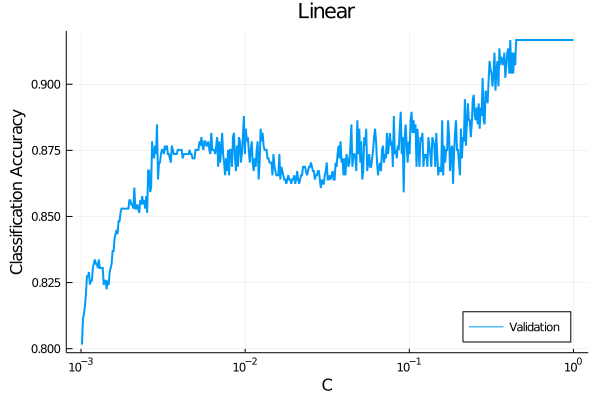

In [29]:
plot(curve.parameter_values,
     curve.measurements,
     xscale=curve.parameter_scale,
     xlab=curve.parameter_name,
     ylab="Classification Accuracy",
     label="Validation", lw=2,
     title="Linear", 
     legend=:bottomright)

In [27]:
fn = "Figures/SVM_Linear_MCC"
png(replace(fn,'.' => ','))

In [32]:
r1 = range(svm_linear_model, :C, lower=10^-2, upper=0.5, scale=:linear)
curve = learning_curve(svm_linear_mach, 
                        range=r1,
                        resampling=CV(), 
                        measure=accuracy, 
                        acceleration=CPUThreads(),
                        resolution=500)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…}} @123.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 500 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 500 metamodels: 100%[=========================] Time: 0:00:08


(parameter_name = "C",
 parameter_scale = :linear,
 parameter_values = [0.010000000000000002, 0.010981963927855713, 0.011963927855711425, 0.012945891783567136, 0.013927855711422847, 0.014909819639278558, 0.01589178356713427, 0.01687374749498998, 0.017855711422845692, 0.018837675350701404  …  0.4911623246492986, 0.4921442885771543, 0.49312625250501, 0.49410821643286573, 0.49509018036072144, 0.49607214428857715, 0.49705410821643287, 0.4980360721442886, 0.4990180360721443, 0.5],
 measurements = [0.8751526251526252, 0.8687728937728939, 0.8735805860805862, 0.8735805860805862, 0.8735805860805862, 0.8607600732600732, 0.8655677655677656, 0.8639652014652014, 0.8655677655677656, 0.8639652014652014  …  0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167],)

┌ Warning: scale linear is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/andrew/.julia/packages/Plots/M1wcx/src/args.jl:1211


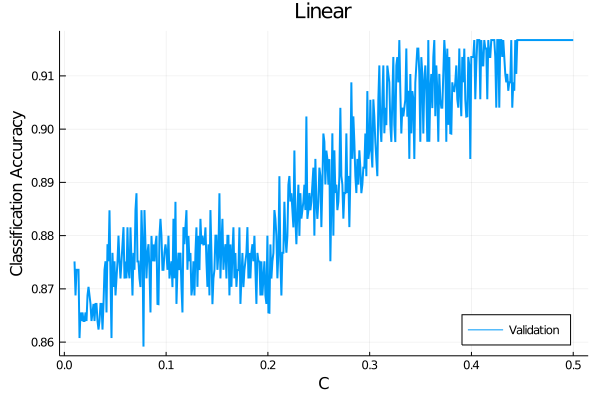

In [34]:
plot(curve.parameter_values,
     curve.measurements,
     xscale=curve.parameter_scale,
     xlab=curve.parameter_name,
     ylab="Classification Accuracy",
     label="Validation", lw=2,
     title="Linear", legend=:bottomright)

In [35]:
a = round(maximum(curve.measurements), digits=5)

0.91673

In [36]:
best_C = curve.parameter_values[argmax(curve.measurements)]

0.32913827655310623

##### More fitting

In [38]:
best_linear_model = SVMClassifier(kernel="linear", C = 0.41)
svm_mach = machine(best_linear_model, X, y)
lf = fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @057.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                 │
├───────────┼───────────────┼────────────────────────────────────────────┤
│ accuracy  │ 0.917         │ [0.943, 0.885, 0.913, 0.923, 0.933, 0.904] │
└───────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


##### Learning Curves

In [39]:
data_schedule, training_losses, valid_losses = learn_curve(best_linear_model, X[train,:], y[train])

(d, train_metric, valid_metric) = (10, 1.0, 0.7045454545454546)
(d, train_metric, valid_metric) = (15, 0.8666666666666667, 0.7159090909090908)
(d, train_metric, valid_metric) = (20, 0.9, 0.8068181818181819)
(d, train_metric, valid_metric) = (25, 0.88, 0.7840909090909091)
(d, train_metric, valid_metric) = (30, 0.9, 0.7840909090909091)
(d, train_metric, valid_metric) = (35, 0.8571428571428572, 0.8295454545454546)
(d, train_metric, valid_metric) = (40, 0.9, 0.8295454545454546)
(d, train_metric, valid_metric) = (45, 0.8666666666666667, 0.8181818181818181)
(d, train_metric, valid_metric) = (50, 0.86, 0.7954545454545454)
(d, train_metric, valid_metric) = (55, 0.9090909090909091, 0.8409090909090909)
(d, train_metric, valid_metric) = (60, 0.9166666666666666, 0.8409090909090909)
(d, train_metric, valid_metric) = (65, 0.9230769230769231, 0.8295454545454546)
(d, train_metric, valid_metric) = (70, 0.9142857142857143, 0.8295454545454546)
(d, train_metric, valid_metric) = (75, 0.92, 0.84090909090909

(10:5:350, Any[1.0, 0.8666666666666667, 0.9, 0.88, 0.9, 0.8571428571428572, 0.9, 0.8666666666666667, 0.86, 0.9090909090909091  …  0.8852459016393442, 0.9225806451612903, 0.9238095238095239, 0.89375, 0.8861538461538462, 0.9121212121212121, 0.9014925373134328, 0.9029411764705882, 0.8956521739130435, 0.9028571428571428], Any[0.7045454545454546, 0.7159090909090908, 0.8068181818181819, 0.7840909090909091, 0.7840909090909091, 0.8295454545454546, 0.8295454545454546, 0.8181818181818181, 0.7954545454545454, 0.8409090909090909  …  0.8636363636363636, 0.9204545454545454, 0.9204545454545454, 0.8977272727272727, 0.8409090909090909, 0.8977272727272727, 0.875, 0.8522727272727273, 0.875, 0.8863636363636364])

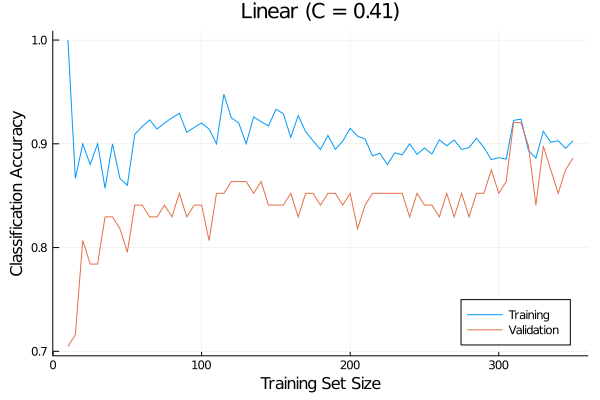

In [41]:
plot(data_schedule, training_losses, label="Training", legend=:bottomright)
plot!(data_schedule, valid_losses, label="Validation")
ylabel!("Classification Accuracy")
xlabel!("Training Set Size")
title!("Linear (C = $(round(best_linear_model.C,digits=5)))")

In [42]:
fn = "Figures/SVM_Linear_LC"
png(replace(fn,'.' => ','))

#### Final Results

Linear SVM

In [43]:
Final_SVM = machine(best_linear_model, X, y)

Machine{SVMClassifier} @519 trained 0 times.
  args: 
    1:	Source @891 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @497 ⏎ `AbstractArray{Multiclass{3},1}`


In [44]:
fit!(Final_SVM, rows=train, verbosity=2)

┌ Info: Training Machine{SVMClassifier} @519.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{SVMClassifier} @519 trained 1 time.
  args: 
    1:	Source @891 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @497 ⏎ `AbstractArray{Multiclass{3},1}`


In [45]:
ŷ = MLJ.predict(Final_SVM, X[test,:]);

In [46]:
accuracy(ŷ, y[test])

0.9037433155080214

In [47]:
c1 = confusion_matrix(ŷ, y[test])

┌ Warning: The classes are un-ordered,
│ using order: ["B", "L", "R"].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:87


              ┌─────────────────────────────────────────┐
              │              Ground Truth               │
┌─────────────┼─────────────┬─────────────┬─────────────┤
│  Predicted  │      B      │      L      │      R      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      B      │     10      │      7      │      5      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      L      │      2      │     68      │      1      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      R      │      1      │      2      │     91      │
└─────────────┴─────────────┴─────────────┴─────────────┘


In [ ]:
19/(19+198)

In [ ]:
19/(19+81)

### Second look at `rbf`

In [49]:
r1 = range(Float64, :C, lower=10^-1, upper=10^4, scale=:log10)
r2 = range(Float64, :gamma, lower=5*10^-5, upper=10^-1, scale=:log10)

MLJBase.NumericRange(Float64, :gamma, ... )

In [50]:
svm_rbf_model = SVMClassifier(kernel="rbf", cache_size=2000)
self_tuning_svm_model = TunedModel(model=svm_rbf_model,
                                    tuning=Grid(goal=500),
                                    resampling=CV(), 
                                    measure=accuracy,
                                    acceleration=CPUThreads(),
                                    range=[r1,r2])

DeterministicTunedModel(
    model = SVMClassifier(
            C = 1.0,
            kernel = "rbf",
            degree = 3,
            gamma = "auto",
            coef0 = 0.0,
            shrinking = true,
            tol = 0.001,
            cache_size = 2000,
            max_iter = -1,
            decision_function_shape = "ovr",
            random_state = nothing),
    tuning = Grid(
            goal = 500,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = accuracy(),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Float64,MLJBase.Bounded,Symbol}[NumericRange{Float64,…} @503, NumericRange{Float64,…} @033],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
 

In [51]:
self_tuning_svm_mach = machine(self_tuning_svm_model, X, y)

Machine{DeterministicTunedModel{Grid,…}} @298 trained 0 times.
  args: 
    1:	Source @998 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @277 ⏎ `AbstractArray{Multiclass{3},1}`


In [52]:
z = fit!(self_tuning_svm_mach, rows=train)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…}} @298.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 484 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 484 metamodels: 100%[=========================] Time: 0:00:13


Machine{DeterministicTunedModel{Grid,…}} @298 trained 1 time.
  args: 
    1:	Source @998 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @277 ⏎ `AbstractArray{Multiclass{3},1}`


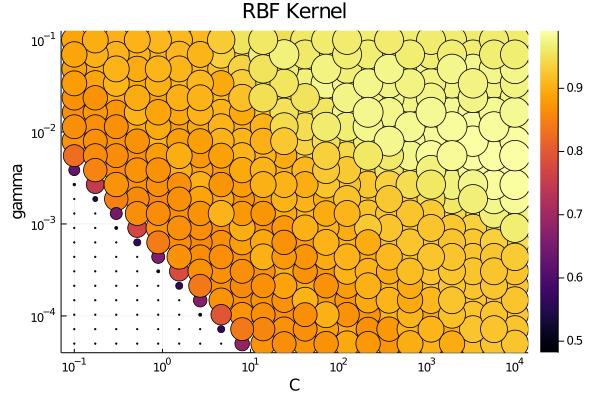

In [53]:
plot(self_tuning_svm_mach, title="RBF Kernel")

In [54]:
fitted_params(self_tuning_svm_mach).best_model

SVMClassifier(
    C = 10000.0,
    kernel = "rbf",
    degree = 3,
    gamma = 0.0038483348970335036,
    coef0 = 0.0,
    shrinking = true,
    tol = 0.001,
    cache_size = 2000,
    max_iter = -1,
    decision_function_shape = "ovr",
    random_state = nothing) @867

In [105]:
r1 = range(Float64, :C, lower=5*10^3, upper=10^6, scale=:log10)
r2 = range(Float64, :gamma, lower=10^-4, upper=5*10^-2, scale=:log10)

MLJBase.NumericRange(Float64, :gamma, ... )

In [106]:
svm_rbf_model = SVMClassifier(kernel="rbf", cache_size=1000)
self_tuning_svm_model = TunedModel(model=svm_rbf_model,
                                    tuning=Grid(goal=500),
                                    resampling=CV(nfolds=5), 
                                    measure=accuracy,
                                    acceleration=CPUThreads(),
                                    range=[r1,r2])

DeterministicTunedModel(
    model = SVMClassifier(
            C = 1.0,
            kernel = "rbf",
            degree = 3,
            gamma = "auto",
            coef0 = 0.0,
            shrinking = true,
            tol = 0.001,
            cache_size = 1000,
            max_iter = -1,
            decision_function_shape = "ovr",
            random_state = nothing),
    tuning = Grid(
            goal = 500,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 5,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = accuracy(),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Float64,MLJBase.Bounded,Symbol}[NumericRange{Float64,…} @784, NumericRange{Float64,…} @327],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
 

In [107]:
self_tuning_svm_mach = machine(self_tuning_svm_model, X, y)

Machine{DeterministicTunedModel{Grid,…}} @866 trained 0 times.
  args: 
    1:	Source @925 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @523 ⏎ `AbstractArray{Multiclass{3},1}`


In [108]:
z = fit!(self_tuning_svm_mach, rows=train)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…}} @866.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 484 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 484 metamodels: 100%[=========================] Time: 0:00:53


Machine{DeterministicTunedModel{Grid,…}} @866 trained 1 time.
  args: 
    1:	Source @925 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @523 ⏎ `AbstractArray{Multiclass{3},1}`


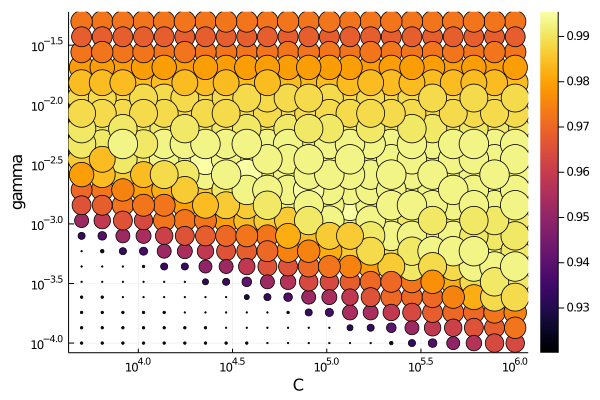

In [109]:
plot(self_tuning_svm_mach)

In [110]:
fn = "Figures/SVM_RBF_MCC"
png(replace(fn,'.' => ','))

In [90]:
best_rbf = fitted_params(self_tuning_svm_mach)
best_rbf

(best_model = SVMClassifier @265,
 best_fitted_params = (support = Int32[18, 130, 156, 158, 178, 192, 193, 253, 262, 306  …  400, 31, 57, 82, 199, 234, 279, 297, 331, 428],
                       support_vectors = [2.0 2.0 1.0 4.0; 1.0 3.0 3.0 1.0; … ; 5.0 1.0 2.0 3.0; 1.0 4.0 5.0 1.0],
                       n_support = Int32[16, 7, 9],
                       dual_coef = [0.0 0.0 … -1942.892247078189 -5725.046920399966; 132867.0046857067 84267.79205810651 … -7535.3342842905595 -0.0],
                       coef = nothing,
                       intercept = [-51.38080343974874, 6.1935019639073, -6.806507599412816],
                       fit_status = 0,
                       classes = UInt32[0x00000001, 0x00000002, 0x00000003],),)

In [91]:
best_rbf.best_model

SVMClassifier(
    C = 132867.0046857067,
    kernel = "rbf",
    degree = 3,
    gamma = 0.0014345028995850935,
    coef0 = 0.0,
    shrinking = true,
    tol = 0.001,
    cache_size = 1000,
    max_iter = -1,
    decision_function_shape = "ovr",
    random_state = nothing) @265

In [92]:
best_loss = round(z.report.best_result.measurement[1],digits=5)

0.99545

In [ ]:
# fn = "Figures/LearningCurve_DT_merge_purity_thresh:$(best_mpt)_loss:$(best_loss)"
# png(replace(fn,'.' => ','))

##### More fitting

In [93]:
best_rbf_model = SVMClassifier(kernel="rbf", C=best_rbf.best_model.C, gamma=best_rbf.best_model.gamma)
svm_mach = machine(best_rbf_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @850.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────┬───────────────┬──────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                       │
├───────────┼───────────────┼──────────────────────────────────┤
│ accuracy  │ 0.997         │ [0.99, 0.99, 1.0, 1.0, 1.0, 1.0] │
└───────────┴───────────────┴──────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


##### Learning Curves

In [94]:
data_schedule, training_losses, valid_losses = learn_curve(best_rbf_model, X[train,:], y[train])

(d, train_metric, valid_metric) = (10, 1.0, 0.7272727272727273)
(d, train_metric, valid_metric) = (15, 1.0, 0.6704545454545454)
(d, train_metric, valid_metric) = (20, 1.0, 0.7954545454545454)
(d, train_metric, valid_metric) = (25, 1.0, 0.8181818181818181)
(d, train_metric, valid_metric) = (30, 1.0, 0.8181818181818181)
(d, train_metric, valid_metric) = (35, 1.0, 0.7727272727272727)
(d, train_metric, valid_metric) = (40, 1.0, 0.7727272727272727)
(d, train_metric, valid_metric) = (45, 1.0, 0.7727272727272727)
(d, train_metric, valid_metric) = (50, 1.0, 0.75)
(d, train_metric, valid_metric) = (55, 1.0, 0.7840909090909091)
(d, train_metric, valid_metric) = (60, 1.0, 0.7840909090909091)
(d, train_metric, valid_metric) = (65, 1.0, 0.8068181818181819)
(d, train_metric, valid_metric) = (70, 1.0, 0.8295454545454546)
(d, train_metric, valid_metric) = (75, 1.0, 0.8295454545454546)
(d, train_metric, valid_metric) = (80, 1.0, 0.8295454545454546)
(d, train_metric, valid_metric) = (85, 1.0, 0.85227272

(10:5:350, Any[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Any[0.7272727272727273, 0.6704545454545454, 0.7954545454545454, 0.8181818181818181, 0.8181818181818181, 0.7727272727272727, 0.7727272727272727, 0.7727272727272727, 0.75, 0.7840909090909091  …  0.9659090909090909, 0.9659090909090909, 0.9772727272727273, 0.9886363636363636, 0.9886363636363636, 0.9886363636363636, 0.9886363636363636, 0.9886363636363636, 0.9886363636363636, 0.9886363636363636])

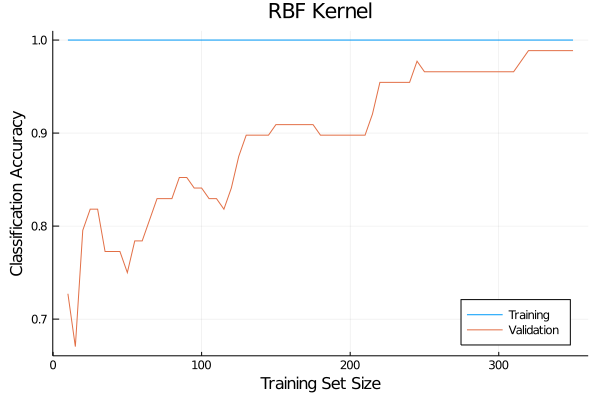

In [95]:
plot(data_schedule, training_losses, label="Training", legend=:bottomright)
plot!(data_schedule, valid_losses, label="Validation")
ylabel!("Classification Accuracy")
xlabel!("Training Set Size")
title!("RBF Kernel")

In [104]:
fn = "Figures/SVM_RBF_LC"
png(replace(fn,'.' => ','))

#### Final Results

RBF SVM

In [96]:
final_svm_rbf = best_rbf.best_model

SVMClassifier(
    C = 132867.0046857067,
    kernel = "rbf",
    degree = 3,
    gamma = 0.0014345028995850935,
    coef0 = 0.0,
    shrinking = true,
    tol = 0.001,
    cache_size = 1000,
    max_iter = -1,
    decision_function_shape = "ovr",
    random_state = nothing) @265

In [97]:
Final_SVM = machine(final_svm_rbf, X, y)

Machine{SVMClassifier} @668 trained 0 times.
  args: 
    1:	Source @260 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @849 ⏎ `AbstractArray{Multiclass{3},1}`


In [98]:
fit!(Final_SVM, rows=train, verbosity=2)

┌ Info: Training Machine{SVMClassifier} @668.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{SVMClassifier} @668 trained 1 time.
  args: 
    1:	Source @260 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @849 ⏎ `AbstractArray{Multiclass{3},1}`


In [99]:
ŷ2 = MLJ.predict(Final_SVM, X[test,:]);

In [100]:
accuracy(ŷ2, y[test])

0.9893048128342246

In [101]:
c2 = confusion_matrix(ŷ2, y[test])

┌ Warning: The classes are un-ordered,
│ using order: ["B", "L", "R"].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:87


              ┌─────────────────────────────────────────┐
              │              Ground Truth               │
┌─────────────┼─────────────┬─────────────┬─────────────┤
│  Predicted  │      B      │      L      │      R      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      B      │     11      │      0      │      0      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      L      │      2      │     77      │      0      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      R      │      0      │      0      │     97      │
└─────────────┴─────────────┴─────────────┴─────────────┘


In [103]:
2/(2+11)

0.15384615384615385